<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/AE%E6%BD%9C%E5%9C%A8%E7%A9%BA%E9%96%93%E3%81%AB%E3%81%8A%E3%81%91%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[DATA] normal=1 | bank=6742 | test_norm=1135 | test_anom=8865
Epoch 01/12  recon MSE=0.081208
Epoch 02/12  recon MSE=0.065449
Epoch 03/12  recon MSE=0.065449
Epoch 04/12  recon MSE=0.065449
Epoch 05/12  recon MSE=0.065449
Epoch 06/12  recon MSE=0.065449
Epoch 07/12  recon MSE=0.065449
Epoch 08/12  recon MSE=0.065449
Epoch 09/12  recon MSE=0.065449
Epoch 10/12  recon MSE=0.065449
Epoch 11/12  recon MSE=0.065449
Epoch 12/12  recon MSE=0.065449
Extracting features (160D) and latent z (32D) ...
PCA explained variance ratio: [0.9589753  0.02196532] (sum=0.981)
[PCA-2D Mahalanobis] AUC=0.9475, AP=0.9927, thr(p99)=3.658


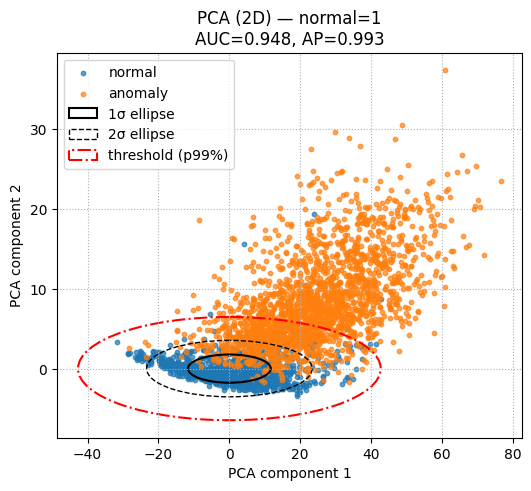

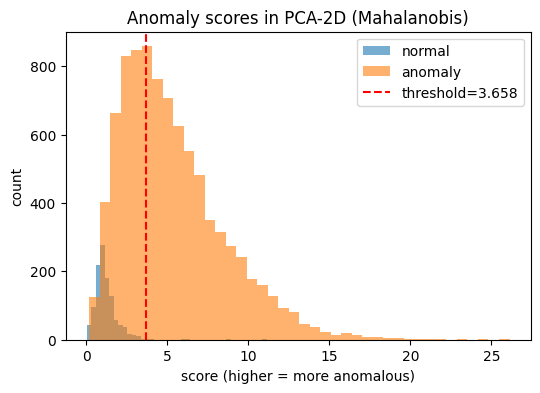

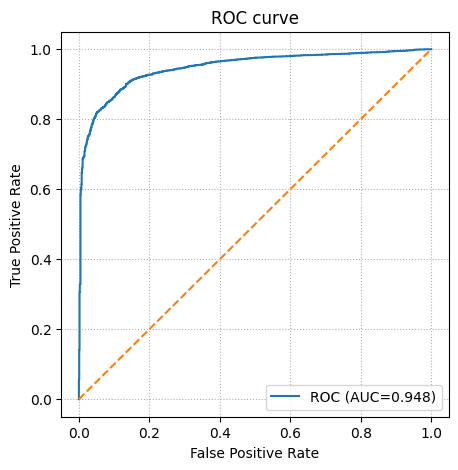

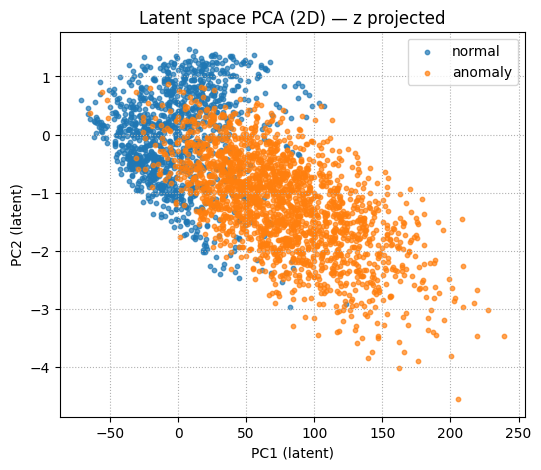

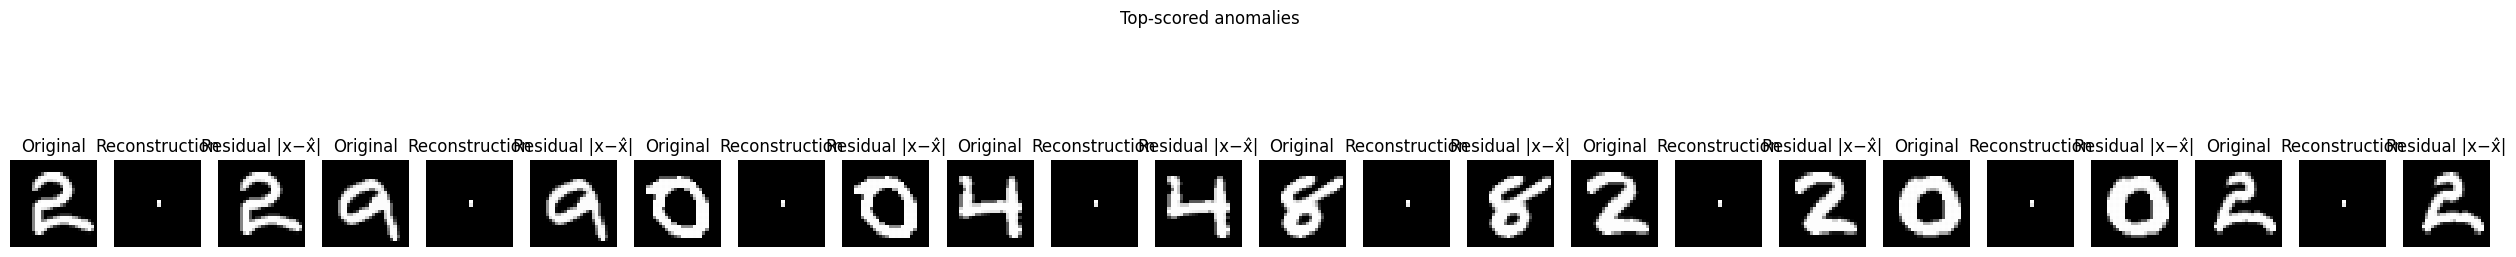

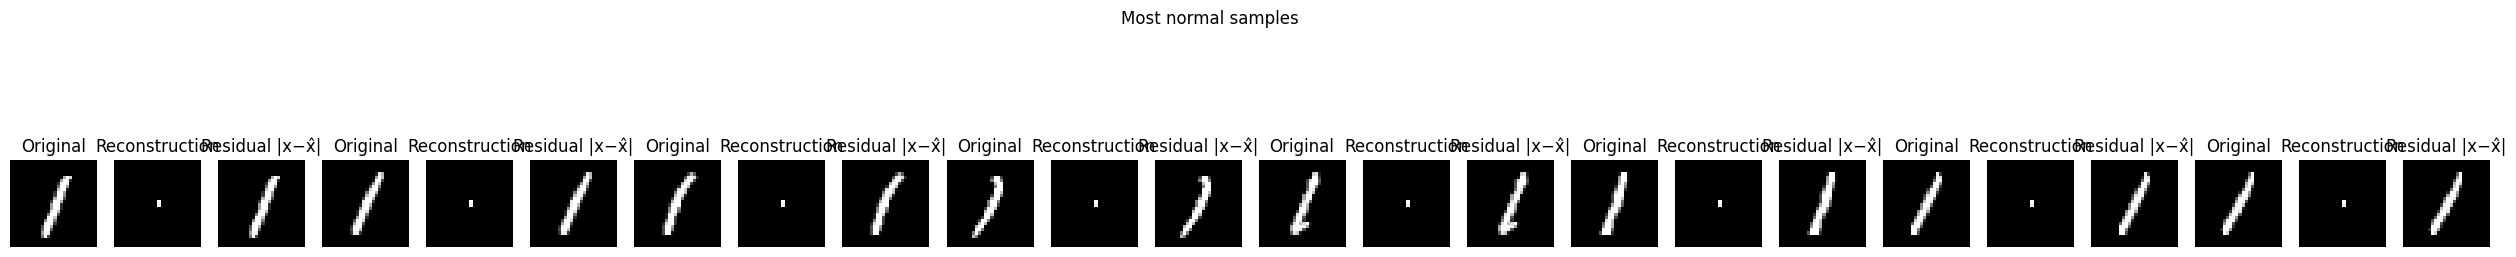

Saved: /content/mnist_pca2_midfeat_z32_normal1.csv

Notes:
- PCA/Scaler are fit only on train-normal features (unsupervised). Test points are projected afterward.
- Score threshold is set from train-normal distances (percentile).
- If separation is weak, try changing NORMAL_DIGIT, increasing EPOCHS, or using cosine metric in PCA space (not shown here).



In [11]:
# Colab one-cell: PCA-only anomaly detection from AE mid features (simple & robust)
# - Train ConvAE on normal-only (one MNIST digit)
# - Image feature = [mid mean(64) | mid std(64) | latent z(32)] = 160D
# - Standardize (fit on train-normal) -> PCA(2D) (fit on train-normal)
# - Score = Mahalanobis distance in PCA-2D w.r.t train-normal
# - Visualize: PCA scatter (ellipses + threshold), score histogram, ROC,
#              latent-z PCA(2D) scatter; plus gallery of originals/recons/residuals

import os, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# sklearn
try:
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc
except Exception:
    import subprocess; subprocess.call(["pip","-q","install","scikit-learn"])
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, auc

# ===== Config =====
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
BATCH = 128
EPOCHS = 12
LR = 1e-3
NORMAL_DIGIT = 1        # which digit is "normal" (0-9)
SAMPLE_PER_CLASS = 2000 # for scatter plots
KDE_GRID = 150          # (not used here; kept for easy extension)
THRESH_PCT = 99.0       # percentile on train-normal distances (threshold ellipse & line)
N_VIZ = 8               # gallery size
SAVE_CSV = True

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ===== Data =====
tfm = transforms.Compose([transforms.ToTensor()])
root = "/content/data"
tr = datasets.MNIST(root, train=True,  download=True, transform=tfm)
te = datasets.MNIST(root, train=False, download=True, transform=tfm)

tr_norm_idx = [i for i,(_,y) in enumerate(tr) if y == NORMAL_DIGIT]
te_norm_idx = [i for i,(_,y) in enumerate(te) if y == NORMAL_DIGIT]
te_anom_idx = [i for i,(_,y) in enumerate(te) if y != NORMAL_DIGIT]

ds_bank = Subset(tr, tr_norm_idx)   # train-normal only
ds_tn   = Subset(te, te_norm_idx)   # test normal
ds_ta   = Subset(te, te_anom_idx)   # test anomaly

def mk_loader(ds, shuffle=False, bs=BATCH):
    return DataLoader(ds, batch_size=bs, shuffle=shuffle, num_workers=2,
                      pin_memory=(DEVICE=="cuda"))

ld_bank = mk_loader(ds_bank, shuffle=True)
ld_tn   = mk_loader(ds_tn,   shuffle=False)
ld_ta   = mk_loader(ds_ta,   shuffle=False)

print(f"[DATA] normal={NORMAL_DIGIT} | bank={len(ds_bank)} | test_norm={len(ds_tn)} | test_anom={len(ds_ta)}")

# ===== Model: ConvAE (latent z=32) =====
class ConvAE(nn.Module):
    def __init__(self, zdim=32):
        super().__init__()
        # Encoder 28->14->7
        self.e1 = nn.Sequential(
            nn.Conv2d(1,32,3,1,1), nn.ReLU(True),
            nn.Conv2d(32,32,3,1,1), nn.ReLU(True),
            nn.MaxPool2d(2)  # 28->14
        )
        self.e2 = nn.Sequential(
            nn.Conv2d(32,64,3,1,1), nn.ReLU(True),
            nn.Conv2d(64,64,3,1,1), nn.ReLU(True),
            nn.MaxPool2d(2)  # 14->7  (mid feature: [64,7,7])
        )
        self.fc_mu = nn.Linear(64*7*7, zdim)
        self.fc_up = nn.Linear(zdim, 64*7*7)
        # Decoder 7->14->28
        self.d1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(64,32,3,1,1), nn.ReLU(True),
            nn.Conv2d(32,32,3,1,1), nn.ReLU(True)  # 14x14
        )
        self.d2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(32,16,3,1,1), nn.ReLU(True),
            nn.Conv2d(16, 1,3,1,1), nn.Sigmoid()   # 28x28
        )
    def encode(self, x, return_mid=False):
        h1 = self.e1(x)
        h2 = self.e2(h1)                 # [B,64,7,7]
        z  = self.fc_mu(h2.flatten(1))   # [B,32]
        return (z, h2) if return_mid else z
    def decode(self, z):
        h = self.fc_up(z).view(-1,64,7,7)
        h = self.d1(h)
        return self.d2(h)
    def forward(self, x):
        z, mid = self.encode(x, return_mid=True)
        x_hat = self.decode(z)
        return x_hat, z, mid

ae = ConvAE(zdim=32).to(DEVICE)
opt = torch.optim.Adam(ae.parameters(), lr=LR)

# ===== Train AE on train-normal only =====
ae.train()
for ep in range(1, EPOCHS+1):
    tot = 0.0; n = 0
    for x,_ in ld_bank:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, _, _ = ae(x)
        loss = F.mse_loss(x_hat, x, reduction="mean")
        opt.zero_grad(); loss.backward(); opt.step()
        bs = x.size(0); tot += float(loss)*bs; n += bs
    print(f"Epoch {ep:02d}/{EPOCHS}  recon MSE={tot/max(1,n):.6f}")
ae.eval()

# ===== Feature extraction =====
@torch.no_grad()
def extract_features(loader, keep_images=False):
    feats, zs = [], []
    xs, xh = [], []
    for x,_ in loader:
        x = x.to(DEVICE, non_blocking=True)
        x_hat, z, mid = ae(x)                 # mid: [B,64,7,7], z: [B,32]
        mu = mid.mean(dim=(2,3))              # [B,64]
        sd = mid.flatten(2).std(dim=2, unbiased=False)  # [B,64]
        f  = torch.cat([mu, sd, z], dim=1)    # [B,160]
        feats.append(f.cpu().numpy())
        zs.append(z.cpu().numpy())
        if keep_images:
            xs.append(x.cpu()); xh.append(x_hat.cpu())
    feats = np.concatenate(feats, axis=0)
    zs = np.concatenate(zs, axis=0)
    if keep_images:
        return feats, zs, torch.cat(xs,0), torch.cat(xh,0)
    return feats, zs

print("Extracting features (160D) and latent z (32D) ...")
F_bank, Z_bank = extract_features(ld_bank, keep_images=False)
F_tn, Z_tn, Xn, Xn_hat = extract_features(ld_tn, keep_images=True)
F_ta, Z_ta, Xa, Xa_hat = extract_features(ld_ta, keep_images=True)

# ===== Standardize & PCA(2D) (fit on train-normal only) =====
scaler = StandardScaler().fit(F_bank)
Fb = scaler.transform(F_bank)
Fn = scaler.transform(F_tn)
Fa = scaler.transform(F_ta)

pca = PCA(n_components=2, random_state=SEED)
Pb = pca.fit_transform(Fb)
Pn = pca.transform(Fn)
Pa = pca.transform(Fa)
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_} (sum={pca.explained_variance_ratio_.sum():.3f})")

# ===== Mahalanobis in PCA-2D (fit on train-normal in PCA space) =====
mu_p = Pb.mean(axis=0)                 # [2]
Xc = Pb - mu_p
S  = (Xc.T @ Xc) / max(1, Xc.shape[0]-1)
eps = 1e-6 * np.trace(S) / S.shape[0]
Si = np.linalg.inv(S + eps*np.eye(2))

def maha2(Z):
    d = Z - mu_p
    m2 = np.einsum("nd,dd,nd->n", d, Si, d)
    return np.sqrt(np.maximum(m2, 0.0))

S_tn = maha2(Pn)
S_ta = maha2(Pa)
dist_bank = maha2(Pb)
thr = np.percentile(dist_bank, THRESH_PCT)

# ===== Metrics =====
labels = np.concatenate([np.zeros_like(S_tn), np.ones_like(S_ta)])
scores = np.concatenate([S_tn, S_ta])
auc_v = roc_auc_score(labels, scores)
ap_v  = average_precision_score(labels, scores)
fpr, tpr, _ = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)
print(f"[PCA-2D Mahalanobis] AUC={auc_v:.4f}, AP={ap_v:.4f}, thr(p{THRESH_PCT:.0f})={thr:.3f}")

# ===== Visualization =====
def sample_idx(n_total, n_pick):
    if n_total <= n_pick: return np.arange(n_total)
    return np.random.default_rng(SEED).choice(n_total, size=n_pick, replace=False)

# 1) PCA scatter with 1σ/2σ ellipses & threshold ellipse
from matplotlib.patches import Ellipse
import numpy.linalg as LA

def plot_cov_ellipse(ax, mean, cov, nsig=1.0, **kwargs):
    vals, vecs = LA.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:,order]
    theta = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    width, height = 2*nsig*np.sqrt(vals)
    e = Ellipse(xy=mean, width=width, height=height, angle=theta, **kwargs)
    ax.add_patch(e)

Pn_s = Pn[sample_idx(len(Pn), SAMPLE_PER_CLASS)]
Pa_s = Pa[sample_idx(len(Pa), SAMPLE_PER_CLASS)]

fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(Pn_s[:,0], Pn_s[:,1], s=10, alpha=0.7, label="normal")
ax.scatter(Pa_s[:,0], Pa_s[:,1], s=10, alpha=0.7, label="anomaly")
plot_cov_ellipse(ax, mu_p, S, nsig=1.0, edgecolor="black", facecolor="none", linewidth=1.5, label="1σ ellipse")
plot_cov_ellipse(ax, mu_p, S, nsig=2.0, edgecolor="black", facecolor="none", linestyle="--", linewidth=1.0, label="2σ ellipse")
plot_cov_ellipse(ax, mu_p, S, nsig=thr, edgecolor="red", facecolor="none", linestyle="-.", linewidth=1.5, label=f"threshold (p{THRESH_PCT:.0f}%)")
ax.set_title(f"PCA (2D) — normal={NORMAL_DIGIT}\nAUC={auc_v:.3f}, AP={ap_v:.3f}")
ax.set_xlabel("PCA component 1"); ax.set_ylabel("PCA component 2")
ax.legend(); ax.grid(True, linestyle=":")
plt.show()

# 2) Score histogram
plt.figure(figsize=(6,4))
plt.hist(S_tn, bins=40, alpha=0.6, label="normal")
plt.hist(S_ta, bins=40, alpha=0.6, label="anomaly")
plt.axvline(thr, linestyle="--", color="red", label=f"threshold={thr:.3f}")
plt.title("Anomaly scores in PCA-2D (Mahalanobis)")
plt.xlabel("score (higher = more anomalous)"); plt.ylabel("count"); plt.legend()
plt.show()

# 3) ROC curve
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC curve")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(); plt.grid(True, linestyle=":")
plt.show()

# 4) Latent z scatter (32D -> PCA-2D for visualization)
pca_z = PCA(n_components=2, random_state=SEED).fit(Z_bank)
Zn2 = pca_z.transform(Z_tn)
Za2 = pca_z.transform(Z_ta)
plt.figure(figsize=(6,5))
plt.scatter(Zn2[sample_idx(len(Zn2), SAMPLE_PER_CLASS),0],
            Zn2[sample_idx(len(Zn2), SAMPLE_PER_CLASS),1], s=10, alpha=0.7, label="normal")
plt.scatter(Za2[sample_idx(len(Za2), SAMPLE_PER_CLASS),0],
            Za2[sample_idx(len(Za2), SAMPLE_PER_CLASS),1], s=10, alpha=0.7, label="anomaly")
plt.title("Latent space PCA (2D) — z projected")
plt.xlabel("PC1 (latent)"); plt.ylabel("PC2 (latent)"); plt.legend(); plt.grid(True, linestyle=":")
plt.show()

# 5) Gallery: Original | Reconstruction | Residual (top anomalies / most normal)
def show_gallery(X, Xhat, title, n=N_VIZ):
    X = X[:n]; Xhat = Xhat[:n]
    resid = (X - Xhat).abs()
    plt.figure(figsize=(4*n, 4))
    for i in range(min(n, X.shape[0])):
        plt.subplot(1, 3*n, 3*i+1); plt.imshow(X[i,0], cmap="gray"); plt.axis("off"); plt.title("Original")
        plt.subplot(1, 3*n, 3*i+2); plt.imshow(Xhat[i,0], cmap="gray"); plt.axis("off"); plt.title("Reconstruction")
        plt.subplot(1, 3*n, 3*i+3); plt.imshow(resid[i,0], cmap="gray"); plt.axis("off"); plt.title("Residual |x−x̂|")
    plt.suptitle(title); plt.show()

# use torch.topk to avoid negative-stride issues
k_a = min(N_VIZ, len(S_ta))
k_n = min(N_VIZ, len(S_tn))
top_a  = torch.topk(torch.from_numpy(S_ta), k=k_a).indices
best_n = torch.topk(torch.from_numpy(-S_tn), k=k_n).indices  # smallest scores

show_gallery(Xa[top_a],  Xa_hat[top_a],  "Top-scored anomalies")
show_gallery(Xn[best_n], Xn_hat[best_n], "Most normal samples")

# ===== Save CSV =====
if SAVE_CSV:
    out_csv = f"/content/mnist_pca2_midfeat_z32_normal{NORMAL_DIGIT}.csv"
    df = {
        "pca_x": np.concatenate([Pn[:,0], Pa[:,0]]),
        "pca_y": np.concatenate([Pn[:,1], Pa[:,1]]),
        "score_pca_mahalanobis": scores,
        "label": np.concatenate([np.zeros_like(S_tn), np.ones_like(S_ta)]).astype(int)
    }
    import pandas as pd
    pd.DataFrame(df).to_csv(out_csv, index=False)
    print("Saved:", out_csv)

print("""
Notes:
- PCA/Scaler are fit only on train-normal features (unsupervised). Test points are projected afterward.
- Score threshold is set from train-normal distances (percentile).
- If separation is weak, try changing NORMAL_DIGIT, increasing EPOCHS, or using cosine metric in PCA space (not shown here).
""")
